## MiniMozart model

This notebook demonstrates how our LSTM model for MiniMozart was made.  Note that the data used for this notebook only comes from 3 midi files, as this is just a demonstration.  The actual model (model.h5 in the main directory) was created using about 50 midi files

## setup

### import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from midi_cleaner import import_midis, inspect_melody_df, midi_to_melody_df, split_melody_dfs

### import data

In [2]:
# 'path' connects to folder with midi files
path = '../raw_data/mozart_midis/'

# load midi files as music21 Streams
midi_list = import_midis(path)

# convert music21 Streams to dataframes, turning unwanted rhythms into 0s
midi_dfs = midi_to_melody_df(midi_list)

# remove unwanted rhythms and make splits of the dataframes where those rhythms were
### this ensures that each dataframe is a true sequence of notes that Mozart wrote without any gaps
note_dfs = split_melody_dfs(midi_dfs)

note_dfs[0].head()

,pitch,duration,beat,measure
0,72,1.00,1.00,1
1,0,1.00,2.00,1
2,77,0.25,3.00,1
3,76,0.25,3.25,1
4,74,0.25,3.50,1


## data preprocessing

### create mapping dictionaries for pitches and durations

In [3]:
# create pitch / duration corpora
pitch_corpus = []
duration_corpus = []

for df in note_dfs:    
    pitch_corpus += list(df['pitch'])
    duration_corpus += list(df['duration'])

In [4]:
# Storing all the unique pitches / durations present in the corpus to buid a mapping dict.
pitch_symb = sorted(list(set(pitch_corpus)))
duration_symb = sorted(list(set(duration_corpus)))

L_pitch_corpus = len(pitch_corpus)  # length of corpus
L_duration_corpus = len(duration_corpus)
L_pitch_symb = len(pitch_symb)  # length of total unique characters
L_duration_symb = len(duration_symb)

# Building dictionary to access the pitches / durations from indices and vice versa
pitch_mapping = dict((int(c), i) for i, c in enumerate(pitch_symb))
pitch_reverse_mapping = dict((i, int(c)) for i, c in enumerate(pitch_symb))
duration_mapping = dict((float(c), i) for i, c in enumerate(duration_symb))
duration_reverse_mapping = dict((i, float(c)) for i, c in enumerate(duration_symb))

# adding padding value to the dictionaries
pitch_mapping[-1] = -1
pitch_reverse_mapping[-1] = -1
duration_mapping[-1.0] = -1
duration_reverse_mapping[-1] = -1.0

print("Total number of pitches:", L_pitch_corpus)
print("Number of unique pitches:", L_pitch_symb)
print("Total number of durations:", L_duration_corpus)
print("Number of unique durations:", L_duration_symb)

Total number of pitches: 2431
Number of unique pitches: 41
Total number of durations: 2431
Number of unique durations: 12


### create sequences

In [5]:
# add -1's to the start of each df

def mask_start_df(df, pad_length):
    mask_df = pd.DataFrame(np.full((pad_length, 4), -1), dtype = 'int64')
    mask_df.columns = ['pitch','duration','beat','measure']
    return pd.concat([mask_df, df])

In [6]:
# Splitting the df's into sequences of equal length (X) and output target (y_p, y_d)

def create_sequences(df_list, length, horizon = 1, selected_features = ['pitch', 'duration']):
    features_list = []
    target_pitch = []
    target_duration = []
    for note_df in df_list:
        df = note_df.copy()
        df = mask_start_df(df, pad_length = (length // 2)) # add padding the to start of each data frame
        L_df = len(df)
        if L_df >= (length + horizon):
            df = df.reset_index()
            df['pitch'] = df['pitch'].astype('int') # to match dictionary keys
            df['duration'] = df['duration'].astype('float') # to match dictionary keys
            df['pitch'] = df['pitch'].map(pitch_mapping)
            df['duration'] = df['duration'].map(duration_mapping)
            latest_start_index = (L_df - length - horizon)
            for i in range(latest_start_index): 
                
                features = df.loc[i:(i + length - 1), selected_features] # minue one to exclude target
                features_list.append(features)

                pitch = df.loc[(i + length), 'pitch']
                target_pitch.append(pitch)
        
                duration = df.loc[(i + length), 'duration']
                target_duration.append(duration)

    L_datapoints = len(target_pitch)
    print("Total number of sequences in the dataset:", L_datapoints)
    
    return np.array(features_list), np.array(target_pitch), np.array(target_duration)

In [7]:
X, y_p, y_d = create_sequences(df_list = note_dfs, length = 8)

Total number of sequences in the dataset: 1900


### inspecting sequences

In [8]:
for i in range(3):
    print('X: \n', X[i])
    print('y_p: ', y_p[i])
    print('y_d: ', y_d[i])
    print('\n')

X: 
 [[-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [19  3]
 [ 0  3]
 [24  0]
 [23  0]]
y_p:  21
y_d:  0


X: 
 [[-1 -1]
 [-1 -1]
 [-1 -1]
 [19  3]
 [ 0  3]
 [24  0]
 [23  0]
 [21  0]]
y_p:  23
y_d:  0


X: 
 [[-1 -1]
 [-1 -1]
 [19  3]
 [ 0  3]
 [24  0]
 [23  0]
 [21  0]
 [23  0]]
y_p:  26
y_d:  0




In [9]:
X.shape

(1900, 8, 2)

In [10]:
y_p.shape, y_d.shape

((1900,), (1900,))

### remove sequences that appear many times

In [11]:
def uniqueish_indexes(X_arr, threshold = 25):
    _, unique_indexes, counts = np.unique(X_arr, axis = 0, return_index = True, return_counts = True)
    return [idx for idx, count in zip(unique_indexes, counts) if count < threshold]

In [12]:
indexes = uniqueish_indexes(X)
X, y_p, y_d = X[indexes], y_p[indexes], y_d[indexes]

In [13]:
y_pitch = y_p.reshape(-1, 1)
y_duration = y_d.reshape(-1,1)
y = {"pitch_output": y_pitch, "duration_output": y_duration}

y_pitch.shape, y_duration.shape

((1101, 1), (1101, 1))

### creating class weights

In [14]:
# get unique values for pitch / duration and their number of occurences
pitch_counts = np.unique(y_p, return_counts=True)
duration_counts = np.unique(y_d, return_counts=True)

# make dict - pitch / duration value: counts
pitch_class_weights_simple = {key:val for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights_simple = {key:val for key, val in zip(duration_counts[0], duration_counts[1])}

# find average count for pitch and duration
pitch_mean = np.mean(list(pitch_class_weights_simple.values()))
duration_mean = np.mean(list(duration_class_weights_simple.values()))

# create class weights - (1 / count) * avg count
pcw = {key:(1 / val) * pitch_mean for key, val in zip(pitch_counts[0], pitch_counts[1])}
dcw = {key:(1 / val) * duration_mean for key, val in zip(duration_counts[0], duration_counts[1])}

# create class weight of 0 for values that are in X but not in y
pcw_keys = list(pcw)
dcw_keys = list(dcw)

for i in range(int(max(pcw_keys))):
    if i not in pcw_keys:
        pcw[i] = 0

for i in range(int(max(dcw_keys))):
    if i not in dcw_keys:
        dcw[i] = 0

In [15]:
print('Baseline Acc pitch: ', round(1 / len(pcw) * 100, 2))
print('Baseline Acc duration: ', round(1 / len(dcw) * 100, 2))

Baseline Acc pitch:  2.44
Baseline Acc duration:  8.33


### creating sample weights

In [16]:
# create arrays that replace y values with class weight values for y
y_pitch_cw = np.array([pcw[pitch] for pitch in y_pitch[:, 0]])
y_dur_cw = np.array([dcw[dur] for dur in y_duration[:, 0]])

# take average value of class weights for y_p and y_d for each sample
sample_weight = ((y_pitch_cw + y_dur_cw) / 2).reshape(-1, 1)
sample_weight.shape

(1101, 1)

In [17]:
sample_weight

array([[0.20595376],
       [0.20595376],
       [0.27340011],
       ...,
       [0.20595376],
       [0.16524119],
       [3.0653921 ]])

## model

### function to plot learning curves

In [18]:
def plot_curves(history):

    fig, axes = plt.subplots(2, 3, figsize = (12, 5))

    axes[0, 0].plot(history['loss'], label = 'Train')
    axes[0, 0].plot(history['val_loss'], label = 'Val')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(history['pitch_output_loss'], label = 'Train')
    axes[0, 1].plot(history['val_pitch_output_loss'], label = 'Val')
    axes[0, 1].set_title('Pitch Loss')
    axes[0, 1].legend()

    axes[0, 2].plot(history['duration_output_loss'], label = 'Train')
    axes[0, 2].plot(history['val_duration_output_loss'], label = 'Val')
    axes[0, 2].set_title('Duration Loss')
    axes[0, 2].legend()

    # axes[1, 0].plot(history['sparse_top_k_categorical_accuracy'])
    # axes[1, 0].plot(history['val_sparse_top_k_categorical_accuracy'])
    # axes[1, 0].set_title('Top K Acc')
    # axes[1, 0].legend();

    axes[1, 1].plot(history['pitch_output_sparse_top_k_categorical_accuracy'], label = 'Train')
    axes[1, 1].plot(history['val_pitch_output_sparse_top_k_categorical_accuracy'], label = 'Val')
    axes[1, 1].set_title('Pitch Top K Acc')
    axes[1, 1].legend()


    axes[1, 2].plot(history['duration_output_sparse_top_k_categorical_accuracy'], label = 'Train')
    axes[1, 2].plot(history['val_duration_output_sparse_top_k_categorical_accuracy'], label = 'Val')
    axes[1, 2].set_title('Duration Top K Acc')
    axes[1, 2].legend()
    plt.tight_layout();

### LSTM model

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

opt = Adam(learning_rate=0.001)
metric = SparseTopKCategoricalAccuracy(k=3, name='sparse_top_k_categorical_accuracy')

def initialize_model():
    
    input_layer = Input(shape=X.shape[1:], name='input_layer')
    first_LSTM = LSTM(32, name='first_LSTM', activation='tanh', return_sequences=True)(input_layer)
#     first_dropout = Dropout(0.1, name='first_dropout')(first_LSTM)

    pitch_LSTM = LSTM(16, name='pitch_LSTM', activation='tanh')(first_LSTM)
    pitch_dropout = Dropout(0.2, name='pitch_dropout')(pitch_LSTM)
    pitch_dense = Dense(16, name='pitch_dense', activation='tanh')(pitch_dropout)
    pitch_dropout_2 = Dropout(0.4, name='pitch_dropout_2')(pitch_dense)
    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(pitch_dropout_2)


    duration_LSTM = LSTM(16, name='duration_LSTM', activation='tanh')(first_LSTM)
    duration_dropout = Dropout(0.2, name='duration_dropout')(duration_LSTM)
    duration_dense = Dense(16, name='duration_dense', activation='tanh')(duration_dropout)
    duration_dropout_2 = Dropout(0.4, name='duration_dropout_2')(duration_dense)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(duration_dropout_2)

    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])

    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
        "duration_output": "sparse_categorical_crossentropy",
    }

    loss_weights = {
        "pitch_output": 1.0, 
        "duration_output": 1.0
    }

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics = metric)

    return model

2022-03-25 10:27:33.819357: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model = initialize_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 8, 2)]       0                                            
__________________________________________________________________________________________________
first_LSTM (LSTM)               (None, 8, 32)        4480        input_layer[0][0]                
__________________________________________________________________________________________________
pitch_LSTM (LSTM)               (None, 16)           3136        first_LSTM[0][0]                 
__________________________________________________________________________________________________
duration_LSTM (LSTM)            (None, 16)           3136        first_LSTM[0][0]                 
______________________________________________________________________________________________

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=16, 
                    epochs=500, 
                    verbose=1, 
                    callbacks=[es], 
                    sample_weight=sample_weight).history

2022-03-25 10:27:34.930532: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
55/55 [==============================] - 9s 41ms/step - loss: 6.0596 - pitch_output_loss: 3.7589 - duration_output_loss: 2.3007 - pitch_output_sparse_top_k_categorical_accuracy: 0.0989 - duration_output_sparse_top_k_categorical_accuracy: 0.7443 - val_loss: 5.2815 - val_pitch_output_loss: 3.5453 - val_duration_output_loss: 1.7361 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.1131 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683
Epoch 2/500
55/55 [==============================] - 1s 10ms/step - loss: 5.7719 - pitch_output_loss: 3.6555 - duration_output_loss: 2.1164 - pitch_output_sparse_top_k_categorical_accuracy: 0.2250 - duration_output_sparse_top_k_categorical_accuracy: 0.8716 - val_loss: 5.0330 - val_pitch_output_loss: 3.5798 - val_duration_output_loss: 1.4532 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.1855 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683
Epoch 3/500
55/55 [==============================] - 1s 10ms/ste

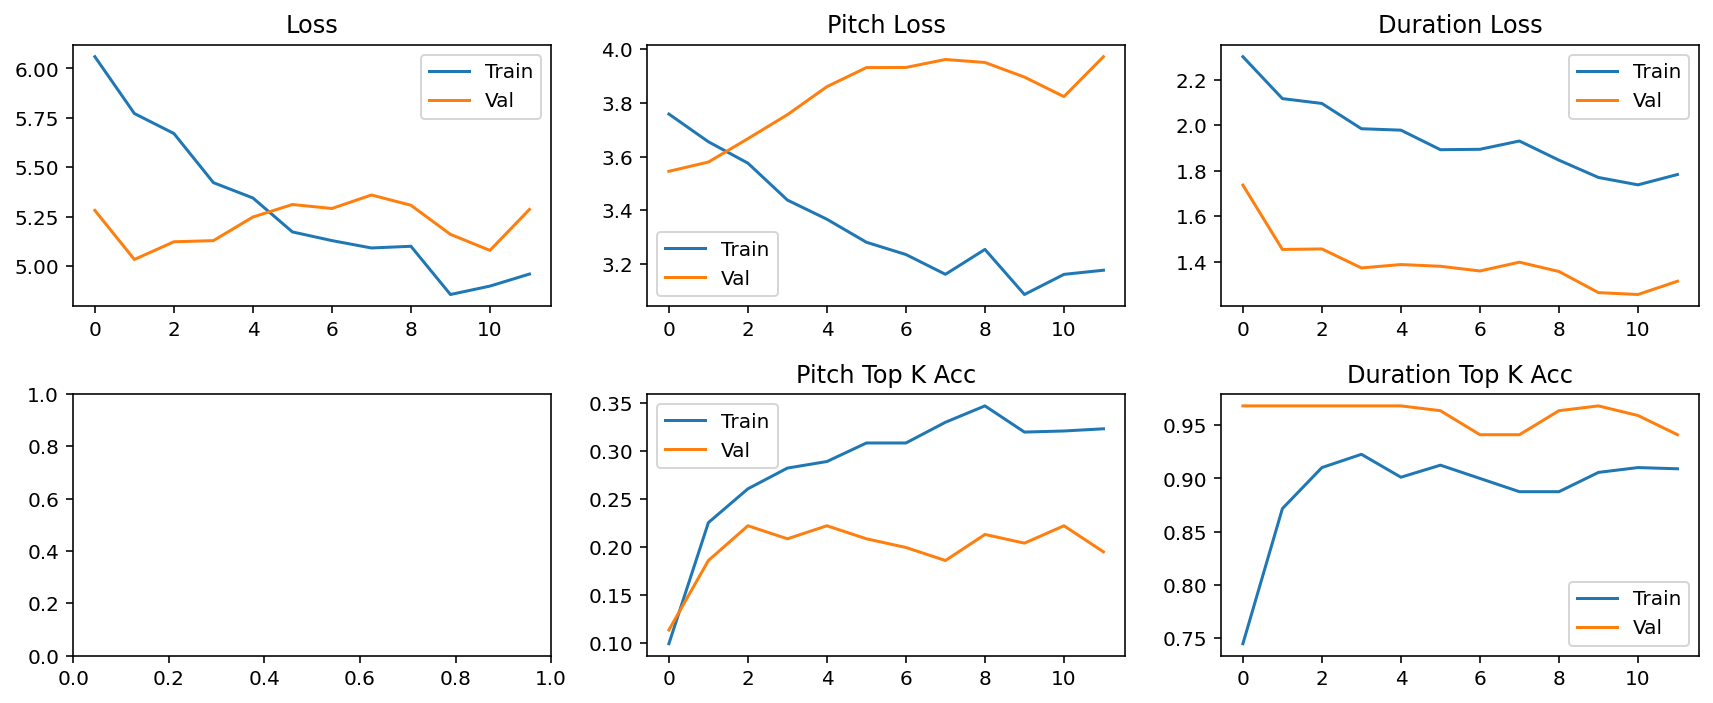

In [22]:
plot_curves(history)

In [23]:
model.save('models/val_loss_lstm.h5')

### continue training, optimizing for pitch accuracy

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'models'
mc = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_pitch_output_sparse_top_k_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
from tensorflow.keras.models import load_model

model = load_model('models/val_loss_lstm.h5')

history = model.fit(X, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=1, 
                    callbacks=[mc], 
                    sample_weight=sample_weight).history

Epoch 1/100
28/28 [==============================] - 5s 62ms/step - loss: 5.6649 - pitch_output_loss: 3.6246 - duration_output_loss: 2.0403 - pitch_output_sparse_top_k_categorical_accuracy: 0.2205 - duration_output_sparse_top_k_categorical_accuracy: 0.9080 - val_loss: 5.0514 - val_pitch_output_loss: 3.6087 - val_duration_output_loss: 1.4427 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2172 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683


2022-03-25 10:29:27.976008: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 2/100
28/28 [==============================] - 0s 17ms/step - loss: 5.6114 - pitch_output_loss: 3.5806 - duration_output_loss: 2.0308 - pitch_output_sparse_top_k_categorical_accuracy: 0.2670 - duration_output_sparse_top_k_categorical_accuracy: 0.8932 - val_loss: 5.0581 - val_pitch_output_loss: 3.6425 - val_duration_output_loss: 1.4156 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2805 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 5.5691 - pitch_output_loss: 3.5654 - duration_output_loss: 2.0038 - pitch_output_sparse_top_k_categorical_accuracy: 0.2750 - duration_output_sparse_top_k_categorical_accuracy: 0.8966 - val_loss: 5.1392 - val_pitch_output_loss: 3.6787 - val_duration_output_loss: 1.4604 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2262 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683
Epoch 4/100
28/28 [==============================] - 0s 12ms/step - loss: 5.4122 - pitch_output_loss: 3.4305 - duration_output_loss: 1.9816 - pitch_output_sparse_top_k_categorical_accuracy: 0.2955 - duration_output_sparse_top_k_categorical_accuracy: 0.9068 - val_loss: 5.1701 - val_pitch_output_loss: 3.7396 - val_duration_output_loss: 1.4305 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2670 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683
Epoch 5/100
28/28 [==============================] - 0s 12ms/ste

28/28 [==============================] - 0s 16ms/step - loss: 4.7868 - pitch_output_loss: 3.1336 - duration_output_loss: 1.6532 - pitch_output_sparse_top_k_categorical_accuracy: 0.3330 - duration_output_sparse_top_k_categorical_accuracy: 0.9068 - val_loss: 5.2172 - val_pitch_output_loss: 3.9324 - val_duration_output_loss: 1.2847 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2081 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9457
Epoch 21/100
28/28 [==============================] - 0s 17ms/step - loss: 4.7848 - pitch_output_loss: 3.0872 - duration_output_loss: 1.6976 - pitch_output_sparse_top_k_categorical_accuracy: 0.3341 - duration_output_sparse_top_k_categorical_accuracy: 0.9273 - val_loss: 5.0746 - val_pitch_output_loss: 3.8123 - val_duration_output_loss: 1.2624 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2172 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9502
Epoch 22/100
28/28 [==============================] - 0s 13ms/step - loss: 

28/28 [==============================] - 0s 12ms/step - loss: 4.4374 - pitch_output_loss: 2.8727 - duration_output_loss: 1.5647 - pitch_output_sparse_top_k_categorical_accuracy: 0.3330 - duration_output_sparse_top_k_categorical_accuracy: 0.8807 - val_loss: 4.7323 - val_pitch_output_loss: 3.5716 - val_duration_output_loss: 1.1607 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2398 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9367
Epoch 38/100
28/28 [==============================] - 0s 12ms/step - loss: 4.4447 - pitch_output_loss: 2.8755 - duration_output_loss: 1.5693 - pitch_output_sparse_top_k_categorical_accuracy: 0.3068 - duration_output_sparse_top_k_categorical_accuracy: 0.9170 - val_loss: 4.9081 - val_pitch_output_loss: 3.7511 - val_duration_output_loss: 1.1571 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2081 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9412
Epoch 39/100
28/28 [==============================] - 0s 12ms/step - loss: 

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 51/100
28/28 [==============================] - 0s 12ms/step - loss: 4.1479 - pitch_output_loss: 2.7199 - duration_output_loss: 1.4280 - pitch_output_sparse_top_k_categorical_accuracy: 0.3534 - duration_output_sparse_top_k_categorical_accuracy: 0.9136 - val_loss: 4.5838 - val_pitch_output_loss: 3.5546 - val_duration_output_loss: 1.0292 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2715 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9412
Epoch 52/100
28/28 [==============================] - 0s 16ms/step - loss: 3.9869 - pitch_output_loss: 2.6385 - duration_output_loss: 1.3484 - pitch_output_sparse_top_k_categorical_accuracy: 0.3477 - duration_output_sparse_top_k_categorical_accuracy: 0.9011 - val_loss: 4.4958 - val_pitch_output_loss: 3.4736 - val_duration_output_loss: 1.0222 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2941 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9367


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 53/100
28/28 [==============================] - 0s 16ms/step - loss: 4.1361 - pitch_output_loss: 2.7338 - duration_output_loss: 1.4022 - pitch_output_sparse_top_k_categorical_accuracy: 0.3636 - duration_output_sparse_top_k_categorical_accuracy: 0.9011 - val_loss: 4.5522 - val_pitch_output_loss: 3.5462 - val_duration_output_loss: 1.0060 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2941 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9593
Epoch 54/100
28/28 [==============================] - 0s 12ms/step - loss: 3.9579 - pitch_output_loss: 2.6335 - duration_output_loss: 1.3243 - pitch_output_sparse_top_k_categorical_accuracy: 0.3477 - duration_output_sparse_top_k_categorical_accuracy: 0.9307 - val_loss: 4.6238 - val_pitch_output_loss: 3.6064 - val_duration_output_loss: 1.0174 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2715 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9321
Epoch 55/100
28/28 [==============================] - 0s 13ms/

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 57/100
28/28 [==============================] - 0s 15ms/step - loss: 3.9419 - pitch_output_loss: 2.6752 - duration_output_loss: 1.2668 - pitch_output_sparse_top_k_categorical_accuracy: 0.3557 - duration_output_sparse_top_k_categorical_accuracy: 0.9023 - val_loss: 4.6864 - val_pitch_output_loss: 3.6740 - val_duration_output_loss: 1.0124 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2851 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9548
Epoch 58/100
28/28 [==============================] - 0s 15ms/step - loss: 3.9445 - pitch_output_loss: 2.6025 - duration_output_loss: 1.3420 - pitch_output_sparse_top_k_categorical_accuracy: 0.3614 - duration_output_sparse_top_k_categorical_accuracy: 0.9216 - val_loss: 4.5409 - val_pitch_output_loss: 3.5485 - val_duration_output_loss: 0.9924 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2941 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9412
Epoch 59/100
28/28 [==============================] - 0s 13ms/

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 61/100
28/28 [==============================] - 0s 14ms/step - loss: 4.0600 - pitch_output_loss: 2.6795 - duration_output_loss: 1.3806 - pitch_output_sparse_top_k_categorical_accuracy: 0.3443 - duration_output_sparse_top_k_categorical_accuracy: 0.9057 - val_loss: 4.6796 - val_pitch_output_loss: 3.6586 - val_duration_output_loss: 1.0210 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3167 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9367


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 62/100
28/28 [==============================] - 0s 15ms/step - loss: 3.9318 - pitch_output_loss: 2.6317 - duration_output_loss: 1.3002 - pitch_output_sparse_top_k_categorical_accuracy: 0.3614 - duration_output_sparse_top_k_categorical_accuracy: 0.9273 - val_loss: 4.4893 - val_pitch_output_loss: 3.4752 - val_duration_output_loss: 1.0141 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3032 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9593
Epoch 63/100
28/28 [==============================] - 0s 12ms/step - loss: 3.9827 - pitch_output_loss: 2.6413 - duration_output_loss: 1.3415 - pitch_output_sparse_top_k_categorical_accuracy: 0.3591 - duration_output_sparse_top_k_categorical_accuracy: 0.9136 - val_loss: 4.5144 - val_pitch_output_loss: 3.5009 - val_duration_output_loss: 1.0135 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3303 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9638


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 64/100
28/28 [==============================] - 0s 16ms/step - loss: 3.8353 - pitch_output_loss: 2.5940 - duration_output_loss: 1.2413 - pitch_output_sparse_top_k_categorical_accuracy: 0.3705 - duration_output_sparse_top_k_categorical_accuracy: 0.9432 - val_loss: 4.5107 - val_pitch_output_loss: 3.5184 - val_duration_output_loss: 0.9924 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2851 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9638
Epoch 65/100
28/28 [==============================] - 0s 13ms/step - loss: 3.7531 - pitch_output_loss: 2.5220 - duration_output_loss: 1.2310 - pitch_output_sparse_top_k_categorical_accuracy: 0.3875 - duration_output_sparse_top_k_categorical_accuracy: 0.9261 - val_loss: 4.4857 - val_pitch_output_loss: 3.4975 - val_duration_output_loss: 0.9882 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3258 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9638
Epoch 66/100
28/28 [==============================] - 0s 13ms/

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 68/100
28/28 [==============================] - 0s 14ms/step - loss: 3.7831 - pitch_output_loss: 2.5596 - duration_output_loss: 1.2235 - pitch_output_sparse_top_k_categorical_accuracy: 0.3591 - duration_output_sparse_top_k_categorical_accuracy: 0.9295 - val_loss: 4.6374 - val_pitch_output_loss: 3.6631 - val_duration_output_loss: 0.9743 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3303 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9502
Epoch 69/100
28/28 [==============================] - 0s 15ms/step - loss: 3.8315 - pitch_output_loss: 2.5697 - duration_output_loss: 1.2618 - pitch_output_sparse_top_k_categorical_accuracy: 0.3580 - duration_output_sparse_top_k_categorical_accuracy: 0.9307 - val_loss: 4.6020 - val_pitch_output_loss: 3.6379 - val_duration_output_loss: 0.9640 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3394 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9548


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 70/100
28/28 [==============================] - 0s 15ms/step - loss: 3.7966 - pitch_output_loss: 2.4966 - duration_output_loss: 1.2999 - pitch_output_sparse_top_k_categorical_accuracy: 0.3739 - duration_output_sparse_top_k_categorical_accuracy: 0.9261 - val_loss: 4.4782 - val_pitch_output_loss: 3.5063 - val_duration_output_loss: 0.9719 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3167 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9593
Epoch 71/100
28/28 [==============================] - 0s 12ms/step - loss: 3.6893 - pitch_output_loss: 2.4790 - duration_output_loss: 1.2103 - pitch_output_sparse_top_k_categorical_accuracy: 0.3807 - duration_output_sparse_top_k_categorical_accuracy: 0.9193 - val_loss: 4.6081 - val_pitch_output_loss: 3.6293 - val_duration_output_loss: 0.9789 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3122 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9457
Epoch 72/100
28/28 [==============================] - 0s 12ms/

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 74/100
28/28 [==============================] - 0s 13ms/step - loss: 3.7056 - pitch_output_loss: 2.4940 - duration_output_loss: 1.2116 - pitch_output_sparse_top_k_categorical_accuracy: 0.3761 - duration_output_sparse_top_k_categorical_accuracy: 0.9182 - val_loss: 4.4985 - val_pitch_output_loss: 3.5479 - val_duration_output_loss: 0.9506 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3484 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 75/100
28/28 [==============================] - 0s 13ms/step - loss: 3.6534 - pitch_output_loss: 2.4561 - duration_output_loss: 1.1973 - pitch_output_sparse_top_k_categorical_accuracy: 0.3966 - duration_output_sparse_top_k_categorical_accuracy: 0.9330 - val_loss: 4.4468 - val_pitch_output_loss: 3.4851 - val_duration_output_loss: 0.9617 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3484 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9502
Epoch 76/100
28/28 [==============================] - 1s 18ms/step - loss: 3.5249 - pitch_output_loss: 2.4073 - duration_output_loss: 1.1175 - pitch_output_sparse_top_k_categorical_accuracy: 0.3784 - duration_output_sparse_top_k_categorical_accuracy: 0.9375 - val_loss: 4.5543 - val_pitch_output_loss: 3.5888 - val_duration_output_loss: 0.9655 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3665 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9593


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 77/100
28/28 [==============================] - 0s 15ms/step - loss: 3.5193 - pitch_output_loss: 2.4104 - duration_output_loss: 1.1089 - pitch_output_sparse_top_k_categorical_accuracy: 0.4080 - duration_output_sparse_top_k_categorical_accuracy: 0.9352 - val_loss: 4.5620 - val_pitch_output_loss: 3.5928 - val_duration_output_loss: 0.9692 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3258 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9638
Epoch 78/100
28/28 [==============================] - 0s 13ms/step - loss: 3.6865 - pitch_output_loss: 2.5324 - duration_output_loss: 1.1540 - pitch_output_sparse_top_k_categorical_accuracy: 0.3489 - duration_output_sparse_top_k_categorical_accuracy: 0.9432 - val_loss: 4.5432 - val_pitch_output_loss: 3.5881 - val_duration_output_loss: 0.9551 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3846 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9593


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Epoch 79/100
28/28 [==============================] - 1s 19ms/step - loss: 3.7741 - pitch_output_loss: 2.4981 - duration_output_loss: 1.2760 - pitch_output_sparse_top_k_categorical_accuracy: 0.3920 - duration_output_sparse_top_k_categorical_accuracy: 0.9295 - val_loss: 4.4674 - val_pitch_output_loss: 3.4938 - val_duration_output_loss: 0.9736 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3348 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9548
Epoch 80/100
28/28 [==============================] - 0s 16ms/step - loss: 3.6071 - pitch_output_loss: 2.3841 - duration_output_loss: 1.2230 - pitch_output_sparse_top_k_categorical_accuracy: 0.3977 - duration_output_sparse_top_k_categorical_accuracy: 0.9386 - val_loss: 4.4481 - val_pitch_output_loss: 3.4724 - val_duration_output_loss: 0.9757 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3801 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9638
Epoch 81/100
28/28 [==============================] - 1s 18ms/

28/28 [==============================] - 0s 12ms/step - loss: 3.3452 - pitch_output_loss: 2.2820 - duration_output_loss: 1.0631 - pitch_output_sparse_top_k_categorical_accuracy: 0.4011 - duration_output_sparse_top_k_categorical_accuracy: 0.9409 - val_loss: 4.5826 - val_pitch_output_loss: 3.6292 - val_duration_output_loss: 0.9534 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3529 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683
Epoch 97/100
28/28 [==============================] - 0s 12ms/step - loss: 3.3848 - pitch_output_loss: 2.3140 - duration_output_loss: 1.0709 - pitch_output_sparse_top_k_categorical_accuracy: 0.3989 - duration_output_sparse_top_k_categorical_accuracy: 0.9466 - val_loss: 4.6708 - val_pitch_output_loss: 3.7332 - val_duration_output_loss: 0.9376 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3394 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9683
Epoch 98/100
28/28 [==============================] - 0s 12ms/step - loss: 

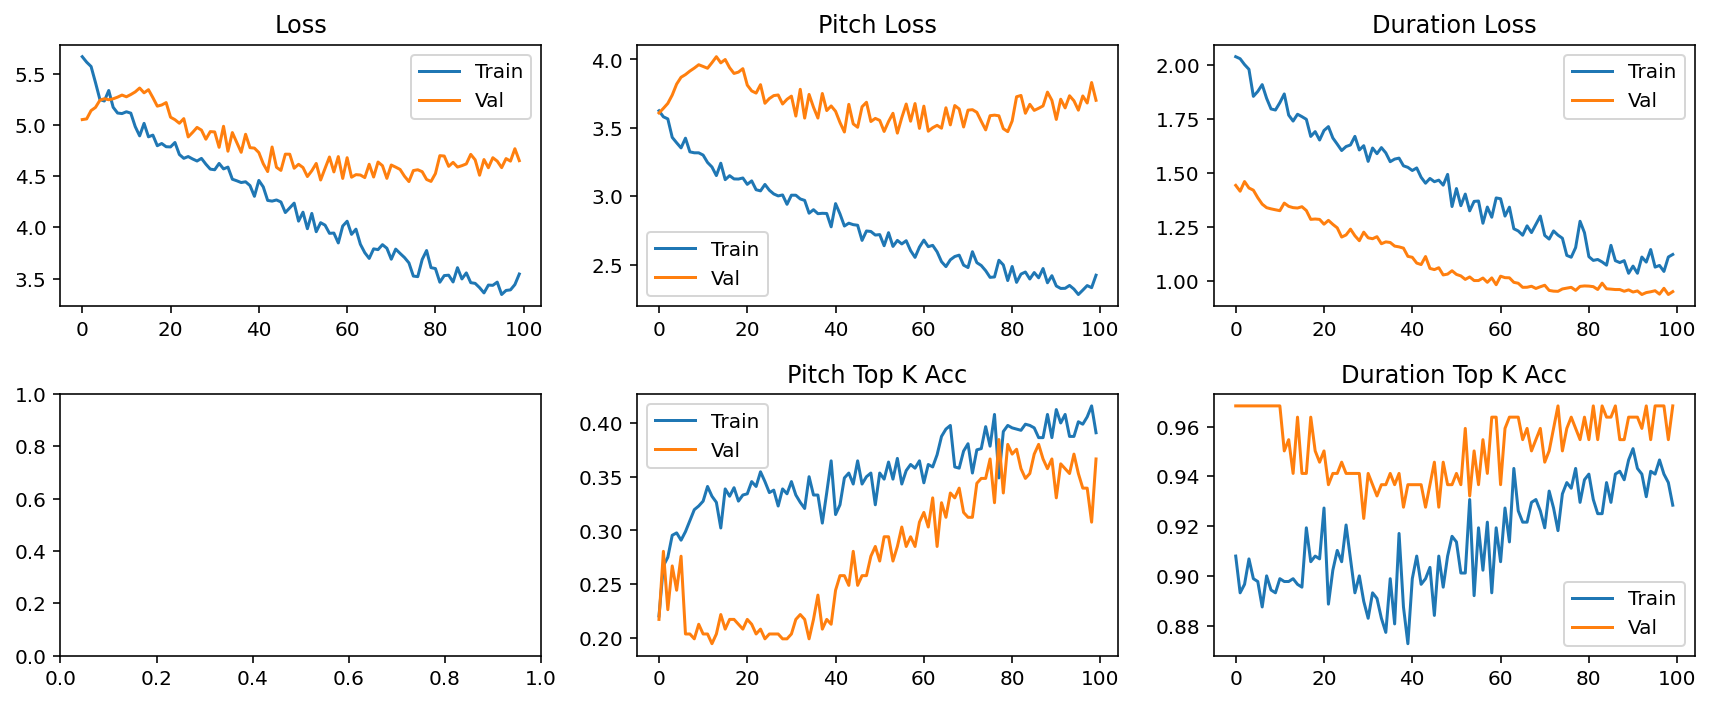

In [28]:
plot_curves(history)

In [29]:
# test that model can be loaded from ModelCheckpoint
model = load_model('models')

In [30]:
# save model as single .h5 file (instead of several different files when using ModelCheckpoint)
model.save('models/best_model.h5')